In [7]:
import datetime
import time as time_module
import sys
import os 
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('../..')
    import covid19_inference as cov19

path_to_save = '../../figures/'
path_save_pickled = '../../data/'
rerun = True
os.getcwd()

'/home/jdehning/covid19/scripts/paper200429'

In [8]:

confirmed_cases = cov19.get_jhu_confirmed_cases()

country = 'Germany'
date_data_begin = datetime.datetime(2020,3,1)
# date_data_end   = cov19.get_last_date(confirmed_cases)
date_data_end = datetime.datetime(2020,4,21)

#date_data_end   = datetime.datetime(2020,3,28)
num_days_data = (date_data_end-date_data_begin).days
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_future = 28
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
date_end_sim   = date_data_end   + datetime.timedelta(days = num_days_future)
num_days_sim = (date_end_sim-date_begin_sim).days


cases_obs = cov19.filter_one_country(confirmed_cases, country,
                                     date_data_begin, date_data_end)

print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5),
                 dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5)]
fact_larger = 4

change_points_days = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 7,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5,
                      pr_sigma_transient_len = 0.3),
                     dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 7,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5,
                      pr_sigma_transient_len = 0.3),
                     dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 7,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5,
                      pr_sigma_transient_len = 0.3)]

change_points_transient = [dict(pr_mean_date_begin_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_begin_transient = 3,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5,
                      pr_sigma_transient_len = 0.3*fact_larger),
                     dict(pr_mean_date_begin_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5,
                      pr_sigma_transient_len = 0.3*fact_larger),
                     dict(pr_mean_date_begin_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_begin_transient = 1,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5,
                      pr_sigma_transient_len = 0.3*fact_larger)]

if rerun:

    traces = []
    models = []
    
    model_delay = cov19.SIR_with_change_points(new_cases_obs = np.diff(cases_obs),
                                        change_points_list = change_points,
                                        date_begin_simulation = date_begin_sim,
                                        num_days_sim = num_days_sim,
                                        diff_data_sim = diff_data_sim,
                                        N = 83e6,
                                        priors_dict= dict(pr_sigma_delay = 0.2*fact_larger),
                                        weekends_modulated=True,
                                        weekend_modulation_type = 'abs_sine')
    models.append(model_delay)
    traces.append(pm.sample(model=model_delay, init='advi+adapt_diag', draws=4000, tune=1000))
    
    model_days = cov19.SIR_with_change_points(new_cases_obs = np.diff(cases_obs),
                                    change_points_list = change_points_days,
                                    date_begin_simulation = date_begin_sim,
                                    num_days_sim = num_days_sim,
                                    diff_data_sim = diff_data_sim,
                                    N = 83e6,
                                    priors_dict = None,
                                    weekends_modulated=True,
                                    weekend_modulation_type = 'abs_sine')
    
    models.append(model_days)
    traces.append(pm.sample(model=model_days, init='advi+adapt_diag', draws=4000, tune=4000))
    
    model_transient = cov19.SIR_with_change_points(new_cases_obs = np.diff(cases_obs),
                                    change_points_list = change_points_transient,
                                    date_begin_simulation = date_begin_sim,
                                    num_days_sim = num_days_sim,
                                    diff_data_sim = diff_data_sim,
                                    N = 83e6,
                                    priors_dict = None,
                                    weekends_modulated=True,
                                    weekend_modulation_type = 'abs_sine')
    
    models.append(model_transient)
    traces.append(pm.sample(model=model_transient, init='advi+adapt_diag', draws=4000, tune=4000))



    pickle.dump([models, traces], open(path_save_pickled + 'SIR_with_sine_with_larger_prior.pickled', 'wb'))

else: 
    models, traces = pickle.load(open(path_save_pickled + 'SIR_with_sine_with_larger_prior.pickled', 'rb'))

    

Cases yesterday (2020-04-21T00:00:00): 148291 and day before yesterday: 147065


In [9]:
exec(open('figures_revised.py').read())

/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2046: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2046: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>
/scratch.local/jdehning/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2046: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.WeekdayLocator'>


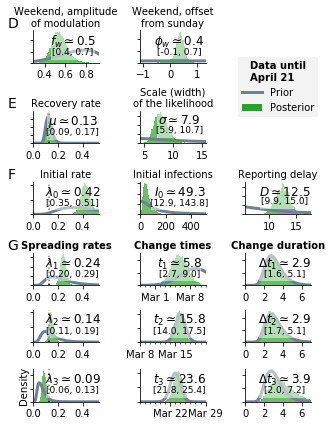

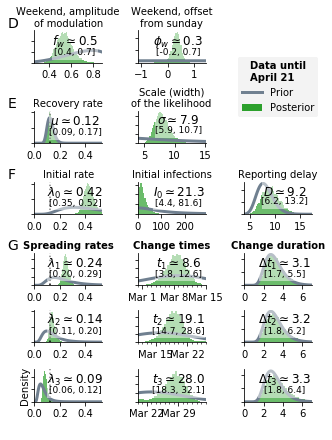

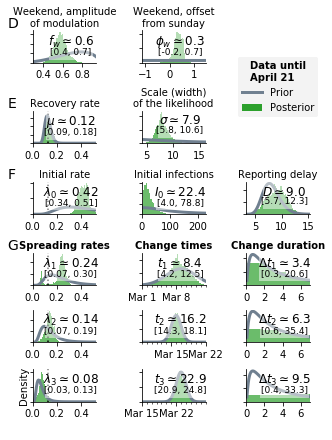

In [11]:
create_figure_distributions(models[0], traces[0],
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:green',
                              num_changepoints=3, xlim_tbegin=7, save_to = path_to_save +'Fig_larger_prior_delay_dist')
create_figure_distributions(models[1], traces[1],
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:green',
                              num_changepoints=3, xlim_tbegin=8, save_to = path_to_save +'Fig_larger_prior_day_dist')
create_figure_distributions(models[2], traces[2],
                              additional_insets = None, xlim_lambda = (0, 0.53), color = 'tab:green',
                              num_changepoints=3, xlim_tbegin=7, save_to = path_to_save +'Fig_larger_prior_transient_dist')


(<Figure size 288x432 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0a3395b7d0>,
       dtype=object))

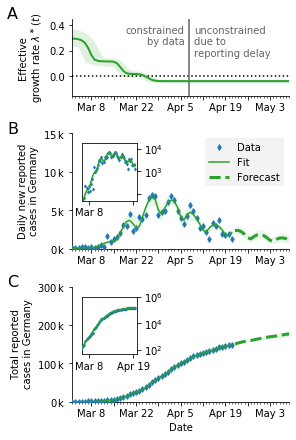

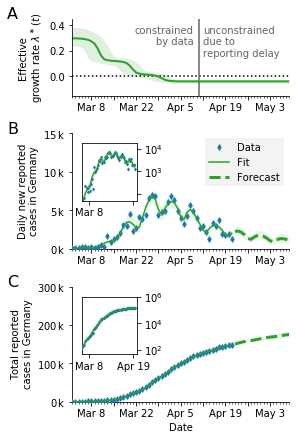

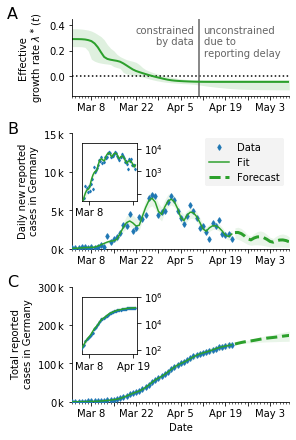

In [5]:
create_figure_timeseries(traces[0], 'tab:green',
                       plot_red_axis=True, save_to = path_to_save +'Fig_larger_prior_delay_cases')
create_figure_timeseries(traces[1], 'tab:green',
                       plot_red_axis=True, save_to = path_to_save +'Fig_larger_prior_day_cases')
create_figure_timeseries(traces[2], 'tab:green',
                       plot_red_axis=True, save_to = path_to_save +'Fig_larger_prior_transient_cases')

In [6]:
print('\nlarge prior delay\n')
print(pm.loo(traces[0], models[0]))

print('\nlarge prior days\n')
print(pm.loo(traces[1], models[1]))

print('\nlarge prior transients\n')
print(pm.loo(traces[2], models[2]))


large prior delay

Computed from 16000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   786.94    17.23
p_loo     14.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       49   96.1%
 (0.5, 0.7]   (ok)          2    3.9%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


large prior days

Computed from 16000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   786.64    16.97
p_loo     14.29        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       48   94.1%
 (0.5, 0.7]   (ok)          3    5.9%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


large prior transients

Computed from 16000 by 51 log-likelihood matrix

       Estimate       SE
IC_loo   785.38    16.93
p_loo     13.92        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       51  100.0